<a href="https://colab.research.google.com/github/menna03/Arabic-Character-Recognition-/blob/main/Arabic_Character_Recognition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from matplotlib.ticker import PercentFormatter
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from scipy.ndimage import rotate
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# File paths
train_images_path = "/content/csvTrainImages 13440x1024.csv"
train_labels_path = "/content/csvTrainLabel 13440x1.csv"
test_images_path="/content/csvTestImages 3360x1024.csv"
test_labels_path="/content/csvTestLabel 3360x1.csv"

# Read CSV files
test_images = pd.read_csv(test_images_path)
test_labels = pd.read_csv(test_labels_path)
train_images = pd.read_csv(train_images_path)
train_labels = pd.read_csv(train_labels_path)

In [ ]:
#Number of unique classes
unique_classes = np.unique(train_labels)
num_classes = len(unique_classes)
print("Number of unique classes:", num_classes)

#Distribution of samples in each class
class_counts = train_labels.value_counts().sort_values(ascending=False)
print("Class distribution:")
print(class_counts)

Number of unique classes: 28
Class distribution:
1 
15    480
2     480
3     480
4     480
5     480
6     480
7     480
8     480
9     480
10    480
11    480
12    480
13    480
14    480
28    480
16    480
17    480
18    480
19    480
20    480
21    480
22    480
23    480
24    480
25    480
26    480
27    480
1     479
dtype: int64


In [ ]:
# Define the normalization function
def normalize_images(images):
    epsilon = 1e-8
    normalized_images = images / (255.0 + epsilon)
    return normalized_images

# Apply normalization to the train and test images
train_images = normalize_images(train_images)
test_images = normalize_images(test_images)

# Print statistics after normalization
print("Statistics of Train Images after normalization:")
print(train_images.describe())

print("\nStatistics of Test Images after normalization:")
print(test_images.describe())


Statistics of Train Images after normalization:
                  0           0.1           0.2           0.3           0.4  \
count  13439.000000  13439.000000  13439.000000  13439.000000  13439.000000   
mean       0.000477      0.000084      0.000038      0.000044      0.000075   
std        0.011108      0.003749      0.002745      0.003240      0.008626   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.501961      0.317647      0.231373      0.341176      1.000000   

                0.5           0.6           0.7           0.8           0.9  \
count  13439.000000  13439.000000  13439.000000  13439.000000  13439.000000   
mean       0.000021      0.000020      0.000082      0.000131      0.000167   
std

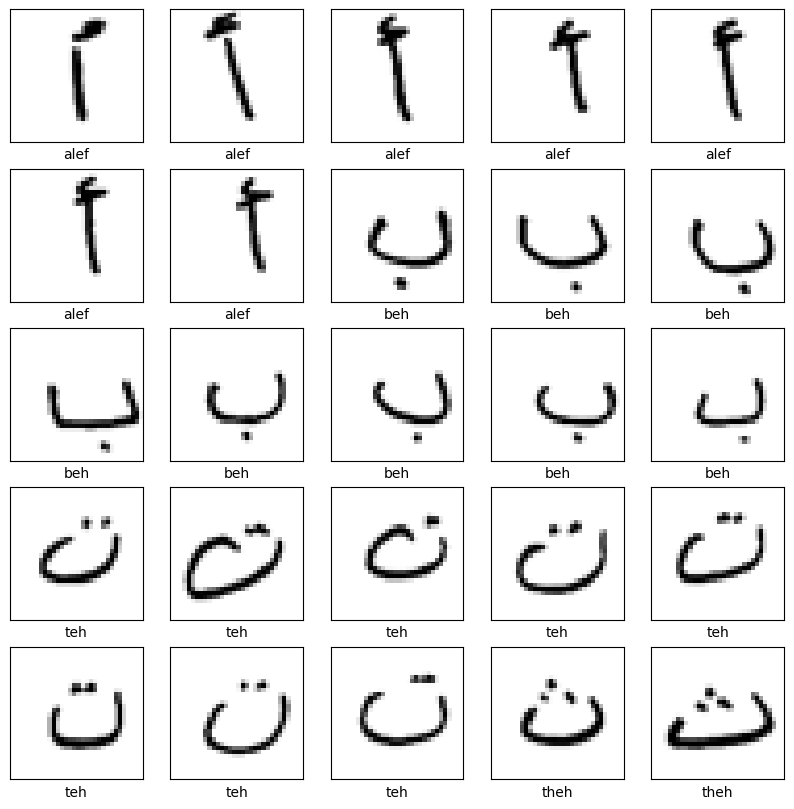

In [ ]:
# Read CSV files
train_images = pd.read_csv(train_images_path)
train_labels = pd.read_csv(train_labels_path)

arabic_characters = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                    'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                    'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

# Reshape the images (assuming 32x32 images, adjust accordingly)
train_images = np.array(train_images).reshape(-1, 32, 32)

# Create a grid of 5x5 images
plt.figure(figsize=(10, 10))
for i in range(25):
    # Rotate the image by 270 degrees (counterclockwise)
    rotated_image = rotate(train_images[i], 270)  # Rotate by 270 degrees, adjust angle as needed

    # Mirror the rotated image horizontally
    mirrored_image = np.flip(rotated_image, axis=1)

    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mirrored_image, cmap=plt.cm.binary)
    label_index = int(train_labels.iloc[i, 0])
    plt.xlabel(arabic_characters[label_index-1])
plt.show()

In [ ]:
# Updated class names
arabic_characters = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                    'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                    'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

# Reshape the images
x_train = np.array(train_images).reshape(-1, 32, 32, 1)
y_train = np.array(train_labels)

# Normalize the pixel values to be between 0 and 1
x_train = x_train / 255.0
y_train=y_train/255.0

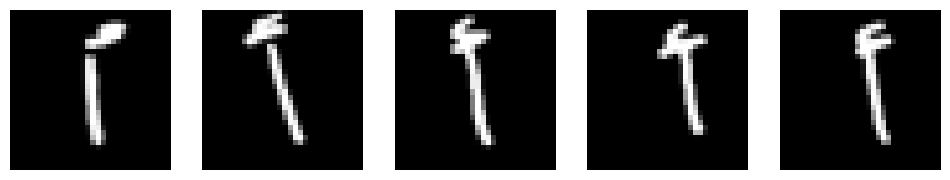

In [ ]:
def batch_reconstruct_and_display_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i in range(num_images):
        image = images[i].reshape(32, 32).T
        axes[i].imshow(image, cmap="gray", interpolation="nearest")
        axes[i].axis('off')

    plt.show()

# Display a batch of images (e.g., first 5 images from train_images)
batch_reconstruct_and_display_images(train_images[:5])


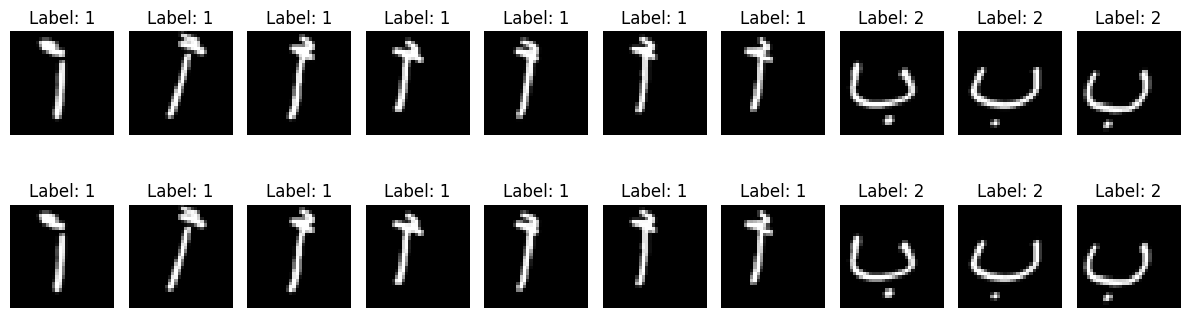

In [ ]:


from scipy.ndimage import rotate

# Function to display images
def display_images(images, labels, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))

    for i in range(num_images):
        rotated_train_image = rotate(images[i].reshape((32, 32)), 270)

        # Access labels using loc for DataFrame or directly for NumPy arrays
        label = labels[i][0] if isinstance(labels, np.ndarray) else labels.iloc[i, 0]

        axes[0, i].imshow(rotated_train_image, cmap='gray')
        axes[0, i].set_title(f"Label: {label}")
        axes[0, i].axis('off')

        # Mirror and rotate testing image (you need the actual testing images to show here)
        axes[1, i].imshow(rotated_train_image, cmap='gray')
        axes[1, i].set_title(f"Label: {label}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Display the first 5 training and testing images (use test_images for testing images)
display_images(train_images, train_labels, num_images=10)


In [ ]:
# Reload the original CSV files
train_images = pd.read_csv(train_images_path)
train_labels = pd.read_csv(train_labels_path)

# Reshape the images (assuming 32x32 images, adjust accordingly)
train_images_reshaped = np.array(train_images).reshape(-1, 32, 32)

# Create a DataFrame from the reshaped images
num_images, width, height = train_images_reshaped.shape
flattened_images = train_images_reshaped.reshape(num_images, -1)
train_images_df = pd.DataFrame(flattened_images)

train_images_normalized = normalize_images(train_images_df)




In [ ]:
train_images_df = pd.DataFrame(train_images)
print(train_images_df.isnull().sum())  # Count NaNs in each column
print(train_images_df.isna().any())   # Check if any NaNs exist

train_images = train_images_df.dropna()  # Remove rows with NaNs
# Or, remove specific columns with NaNs:
train_images = train_images.dropna(axis=1)


imputer = SimpleImputer(strategy='mean')  # Replace NaNs with mean
train_images = imputer.fit_transform(train_images)

#normalize images after handling
train_images = normalize_images(train_images)

model = DecisionTreeClassifier()
model.fit(train_images, train_labels.iloc[:, 0])


if len(train_images) != len(train_labels):
    min_length = min(len(train_images), len(train_labels))
    train_images = train_images.iloc[:min_length, :]
    train_labels = train_labels.iloc[:min_length]

# Verify alignment
assert len(train_images) == len(train_labels), "Number of labels and samples still don't match"


#Train the SVM model
svm=SVC()
svm.fit(train_images,train_labels.iloc[:,0])

#Test the model
predictions= svm.predict(test_images)



# Average F1-score
average_f1 = f1_score(test_labels.iloc[:, 0], predictions, average='weighted')
print("Average F1-score:", average_f1)

0        0
0.1      0
0.2      0
0.3      0
0.4      0
        ..
0.901    0
0.902    0
0.903    0
0.904    0
0.905    0
Length: 1024, dtype: int64
0        False
0.1      False
0.2      False
0.3      False
0.4      False
         ...  
0.901    False
0.902    False
0.903    False
0.904    False
0.905    False
Length: 1024, dtype: bool


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Average F1-score: 0.6529855738309264


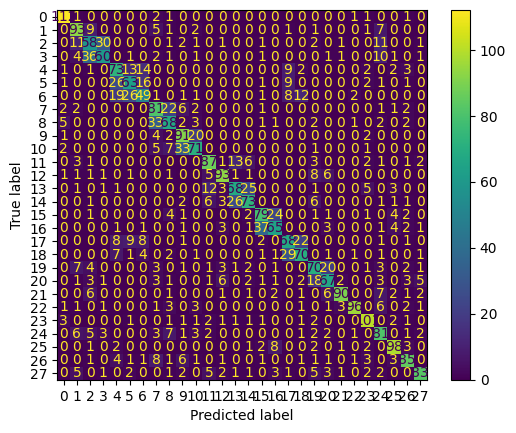

In [ ]:
#Confusion matrix
Confusion_Matrix = confusion_matrix(test_labels.iloc[:,0], predictions)
ConfusionMatrixDisplay(Confusion_Matrix).plot()

# Second Experiment: KNN

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Define different K values to try
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Reshape the training data
X_train_2d = X_train.reshape(X_train.shape[0], -1)

# Train KNN models with different K values and compute average F1 scores and accuracy
average_f1_scores = []
accuracies = []
for k in k_values:
    # Create and fit KNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_2d, y_train)

    # Predict labels for validation dataset
    X_val_2d = X_val.reshape(X_val.shape[0], -1)
    y_pred = knn.predict(X_val_2d)

    # Compute F1 score
    f1 = f1_score(y_val, y_pred, average='macro')
    average_f1_scores.append(f1)

    # Compute accuracy
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)



/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

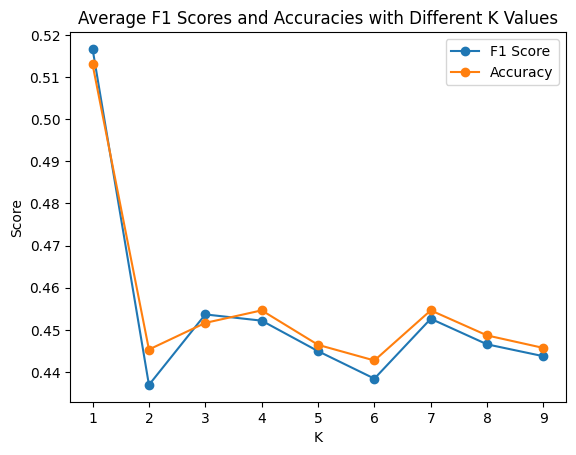

In [ ]:
# Plot average F1 scores and accuracies with different K values
plt.plot(k_values, average_f1_scores, marker='o', label='F1 Score')
plt.plot(k_values, accuracies, marker='o', label='Accuracy')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Average F1 Scores and Accuracies with Different K Values')
plt.legend()
plt.show()



In [ ]:
# Find the best K values
best_k = k_values[np.argmax(average_f1_scores)]
print("Best K value:", best_k)

Best K value: 1


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Average F1 Score for Testing Dataset: 0.5394510159446276


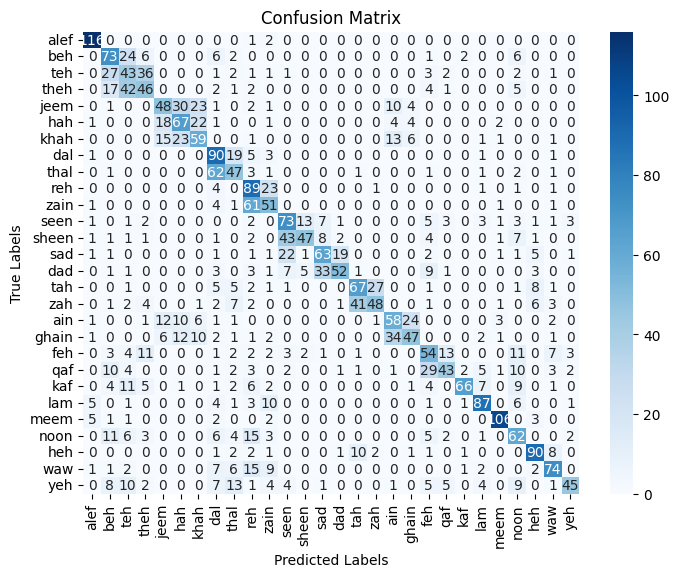

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the training and testing data
X_train_2d = X_train.reshape(X_train.shape[0], -1)
test_images_2d = test_images.values.reshape(test_images.shape[0], -1)

# Create and fit KNN model with the best K value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_2d, y_train)

# Predict labels for testing dataset
y_test_pred = best_knn.predict(test_images_2d)

# Compute and print average F1 score for testing dataset
test_f1 = f1_score(test_labels, y_test_pred, average='macro')
print("Average F1 Score for Testing Dataset:", test_f1)

# Compute confusion matrix for testing dataset
confusion_mat = confusion_matrix(test_labels, y_test_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",xticklabels=arabic_characters,yticklabels=arabic_characters)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()

#  Convolutional neural network (CNN)

Differences:

Number of Filters:
Model 2 has more filters (64) in its convolutional layer compared
Model 1 (32).
Number of Neurons:
Model 2 has more neurons in its dense layer (256) compared
Model 1 (128).


In [ ]:
# File paths
train_images_path = "/content/csvTrainImages 13440x1024.csv"
train_labels_path = "/content/csvTrainLabel 13440x1.csv"
test_images_path="/content/csvTestImages 3360x1024.csv"
test_labels_path="/content/csvTestLabel 3360x1.csv"

# Read CSV files
test_images = pd.read_csv(test_images_path)
test_labels = pd.read_csv(test_labels_path)
train_images = pd.read_csv(train_images_path)
train_labels = pd.read_csv(train_labels_path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow import keras
from tensorflow.keras import layers


# Updated class names
arabic_characters = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                    'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                    'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

# Reshape the images
x_train = np.array(train_images).reshape(-1, 32, 32, 1)
y_train = np.array(train_labels)

# Normalize the pixel values to be between 0 and 1
x_train = x_train / 255.0
y_train=y_train/255.0

In [ ]:
# Print the shape of the training dataset
print("Training Data Shape:", x_train.shape, y_train.shape)
# Define the first neural network model
model1 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(arabic_characters), activation='softmax')  # Update the number of units
])




Training Data Shape: (13439, 32, 32, 1) (13439, 1)


In [ ]:
# Reshape the images
x_train = np.array(train_images).reshape(-1, 32, 32, 1)

# Normalize the pixel values to be between 0 and 1
x_train = x_train / 255.0

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels.values.reshape(-1))
y_train_onehot = keras.utils.to_categorical(y_train_encoded)

# Print the shape of the training dataset
print("Training Data Shape:", x_train.shape, y_train_onehot.shape)

# Define the first neural network model
model1 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(arabic_characters), activation='softmax')  # Update the number of units
])

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the first model
history1 = model1.fit(x_train, y_train_onehot, epochs=10, validation_split=0.2)


Training Data Shape: (13439, 32, 32, 1) (13439, 28)
Epoch 1/10
336/336 [==============================] - 6s 16ms/step - loss: 1.9685 - accuracy: 0.4215 - val_loss: 1.4619 - val_accuracy: 0.5513
Epoch 2/10
336/336 [==============================] - 5s 15ms/step - loss: 0.9243 - accuracy: 0.7099 - val_loss: 1.1242 - val_accuracy: 0.6410
Epoch 3/10
336/336 [==============================] - 5s 15ms/step - loss: 0.5916 - accuracy: 0.8116 - val_loss: 0.9498 - val_accuracy: 0.6953
Epoch 4/10
336/336 [==============================] - 5s 16ms/step - loss: 0.4043 - accuracy: 0.8702 - val_loss: 0.9074 - val_accuracy: 0.7333
Epoch 5/10
336/336 [==============================] - 5s 14ms/step - loss: 0.2955 - accuracy: 0.9052 - val_loss: 0.8734 - val_accuracy: 0.7396
Epoch 6/10
336/336 [==============================] - 5s 16ms/step - loss: 0.1994 - accuracy: 0.9435 - val_loss: 0.9618 - val_accuracy: 0.7336
Epoch 7/10
336/336 [==============================] - 5s 15ms/step - loss: 0.1589 - accura

In [ ]:
# Define the second neural network model
model2 = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(arabic_characters), activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the second model
history2 = model2.fit(x_train, y_train_onehot, epochs=10, validation_split=0.2)



Epoch 1/10
336/336 [==============================] - 14s 40ms/step - loss: 1.7117 - accuracy: 0.4793 - val_loss: 1.2131 - val_accuracy: 0.6086
Epoch 2/10
336/336 [==============================] - 14s 40ms/step - loss: 0.6945 - accuracy: 0.7724 - val_loss: 0.9439 - val_accuracy: 0.6916
Epoch 3/10
336/336 [==============================] - 13s 40ms/step - loss: 0.3937 - accuracy: 0.8699 - val_loss: 0.9123 - val_accuracy: 0.7221
Epoch 4/10
336/336 [==============================] - 14s 43ms/step - loss: 0.2425 - accuracy: 0.9221 - val_loss: 0.9148 - val_accuracy: 0.7362
Epoch 5/10
336/336 [==============================] - 14s 42ms/step - loss: 0.1484 - accuracy: 0.9543 - val_loss: 0.9220 - val_accuracy: 0.7560
Epoch 6/10
336/336 [==============================] - 13s 40ms/step - loss: 0.1038 - accuracy: 0.9674 - val_loss: 0.9207 - val_accuracy: 0.7664
Epoch 7/10
336/336 [==============================] - 13s 40ms/step - loss: 0.0687 - accuracy: 0.9814 - val_loss: 0.9662 - val_accuracy:

Text(0.5, 1.0, 'Model 1: Training and Validation Loss')

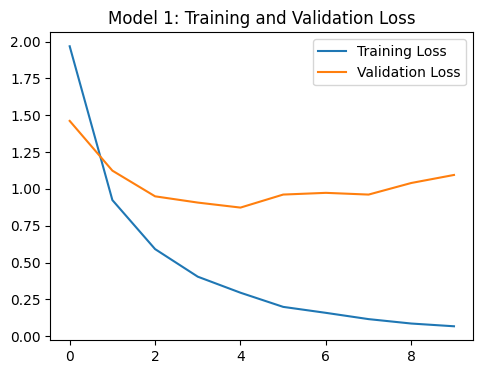

In [ ]:
# Plot the training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model 1: Training and Validation Loss')


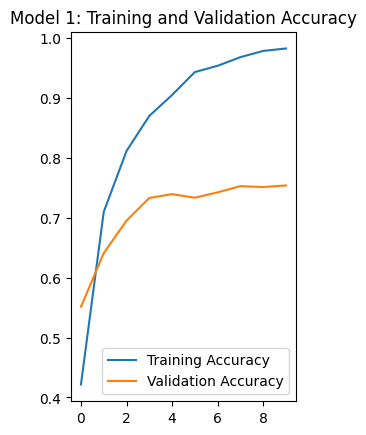

In [ ]:

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model 1: Training and Validation Accuracy')

plt.show()


In [ ]:
from tensorflow.keras.optimizers import Adam

model1.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
model2.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
# Save the first model
model1.save('/content/drive/MyDrive/ML FCAI/model1.h5')
model2.save('/content/drive/MyDrive/ML FCAI/model2.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the saved models
loaded_model1 = keras.models.load_model('/content/drive/MyDrive/ML FCAI/model1.h5')
loaded_model2 = keras.models.load_model('/content/drive/MyDrive/ML FCAI/model2.h5')



In [ ]:
model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 7200)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               921728    
                                                                 
 dense_3 (Dense)             (None, 28)                3612      
                                                                 
Total params: 925660 (3.53 MB)
Trainable params: 925660 (3.53 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 14400)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               3686656   
                                                                 
 dense_5 (Dense)             (None, 28)                7196      
                                                                 
Total params: 3694492 (14.09 MB)
Trainable params: 3694492 (14.09 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
# Reshape the testing images
x_test = np.array(test_images).reshape(-1, 32, 32, 1)

# Normalize the pixel values to be between 0 and 1
x_test = x_test / 255.0


In [ ]:
# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(test_labels.values.reshape(-1))


In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert the encoded labels to one-hot encoding
y_test_onehot = to_categorical(y_test_encoded)

In [ ]:
y_test = label_encoder.inverse_transform(y_test_encoded)

In [ ]:
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (3359, 32, 32, 1)
y_test shape: (3359,)


In [ ]:
print("Number of samples in y_test_encoded:", len(y_test_encoded))


Number of samples in y_test_encoded: 3359


In [ ]:
# Assuming you have a variable num_classes representing the number of classes in your model
num_classes = 28  # Replace with the actual number of classes

# Ensure consistent label encoding
unique_labels = np.unique(y_test_encoded)
print("Number of unique labels in y_test_encoded:", len(unique_labels))




Number of unique labels in y_test_encoded: 28


In [ ]:
# Check if any label is out of range
if np.max(unique_labels) >= num_classes or np.min(unique_labels) < 0:
    print("Error: Labels are out of range.")
else:
    print("Label encoding seems consistent.")



Label encoding seems consistent.


In [ ]:
# Evaluate the models on the testing dataset
test_loss1, test_accuracy1 = loaded_model1.evaluate(x_test, y_test_onehot)
test_loss2, test_accuracy2 = loaded_model2.evaluate(x_test, y_test_onehot)

# Print the testing accuracies
print("Model 1 Testing Accuracy:", test_accuracy1)
print("Model 2 Testing Accuracy:", test_accuracy2)

105/105 [==============================] - 1s 8ms/step - loss: 0.6964 - accuracy: 0.8241
Model 1 Testing Accuracy: 0.8231616616249084
Model 2 Testing Accuracy: 0.8240547776222229


In [ ]:

# Get predictions on the testing dataset
predictions1 = np.argmax(loaded_model1.predict(x_test), axis=1)
predictions2 = np.argmax(loaded_model2.predict(x_test), axis=1)

# Calculate and print confusion matrices
conf_matrix1 = confusion_matrix(np.argmax(y_test_onehot, axis=1), predictions1)
conf_matrix2 = confusion_matrix(np.argmax(y_test_onehot, axis=1), predictions2)



105/105 [==============================] - 1s 8ms/step


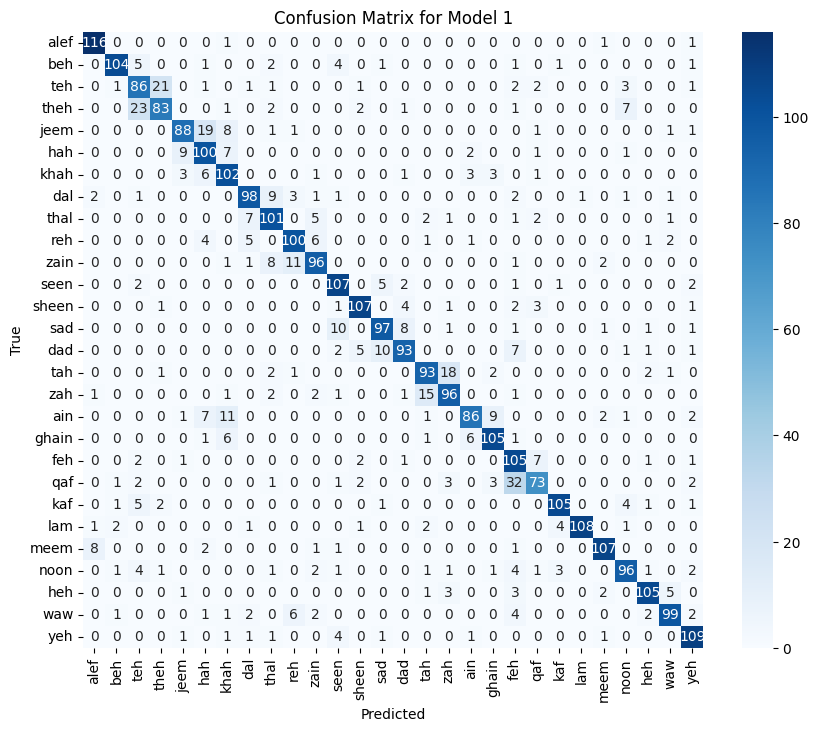

In [ ]:
# Plotting confusion matrix for Model 1
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix1, annot=True, fmt="d", cmap='Blues', xticklabels=arabic_characters, yticklabels=arabic_characters)
plt.title('Confusion Matrix for Model 1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


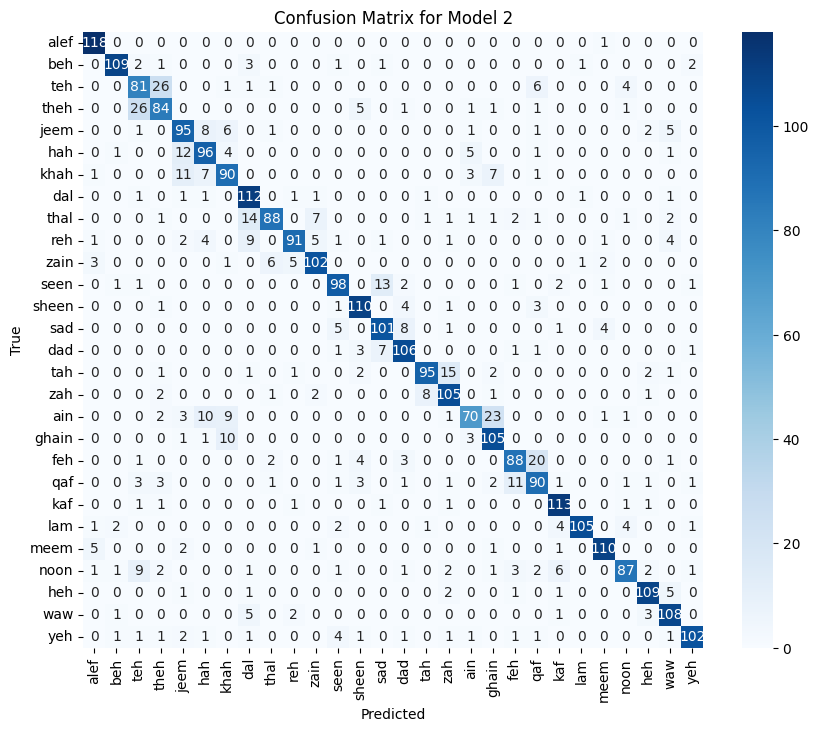

In [ ]:

# Plotting confusion matrix for Model 2
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix2, annot=True, fmt="d", cmap='Blues', xticklabels=arabic_characters, yticklabels=arabic_characters)
plt.title('Confusion Matrix for Model 2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Evaluate the models on the testing dataset
test_loss1, test_accuracy1 = loaded_model1.evaluate(x_test, y_test_onehot)
test_loss2, test_accuracy2 = loaded_model2.evaluate(x_test, y_test_onehot)

# Print the testing accuracies
print("Model 1 Testing Accuracy:", test_accuracy1)
print("Model 2 Testing Accuracy:", test_accuracy2)


105/105 [==============================] - 1s 8ms/step - loss: 0.6964 - accuracy: 0.8241
Model 1 Testing Accuracy: 0.8231616616249084
Model 2 Testing Accuracy: 0.8240547776222229


In [ ]:

# Calculate and print F1 scores
f1_score1 = f1_score(np.argmax(y_test_onehot, axis=1), predictions1, average='weighted')
f1_score2 = f1_score(np.argmax(y_test_onehot, axis=1), predictions2, average='weighted')

print("F1 Score 1:", f1_score1)
print("F1 Score 2:", f1_score2)

F1 Score 1: 0.8237217098336763
F1 Score 2: 0.8235381739593085


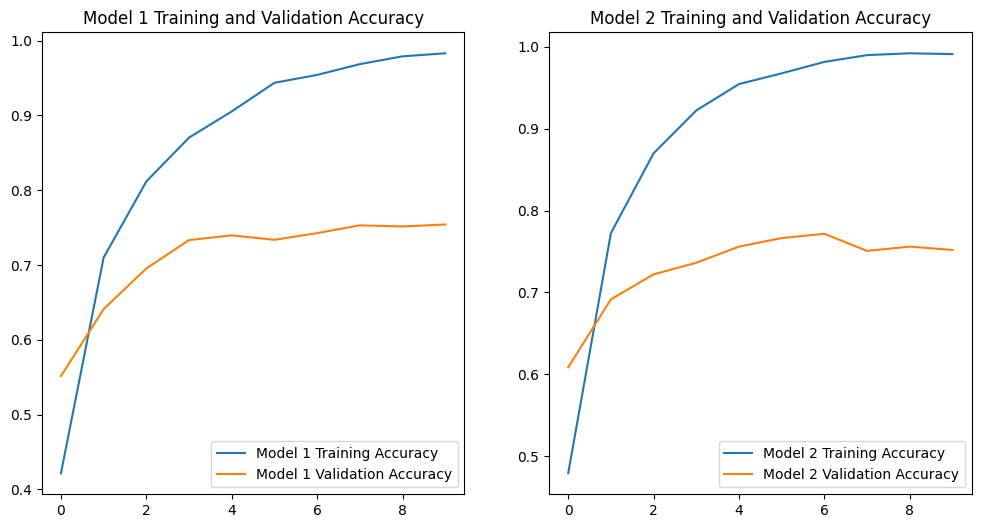

In [ ]:

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
# Model 1
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Model 1 Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Model 1 Validation Accuracy')
plt.legend()
plt.title('Model 1 Training and Validation Accuracy')

# Model 2
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Model 2 Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Model 2 Validation Accuracy')
plt.legend()
plt.title('Model 2 Training and Validation Accuracy')

plt.show()


# Feedforward neural networks

**Model 1:**

Input layer with 1024 input dimensions.

One hidden layer with 256 units and ReLU activation.

Another hidden layer with 128 units and ReLU activation.

Output layer with the number of units equal to the number of classes, using softmax activation for multi-class classification.


**Model 2:**

Input layer with 1024 input dimensions.

Three hidden layers with increasing units: 512, 256, and 128, all using ReLU activation.

Output layer with the number of units equal to the number of classes, using softmax activation for multi-class classification.

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
train_images = pd.read_csv("csvTrainImages 13440x1024.csv", header=None)
train_labels = pd.read_csv("csvTrainLabel 13440x1.csv", header=None)
test_images = pd.read_csv("csvTestImages 3360x1024.csv", header=None)
test_labels = pd.read_csv("csvTestLabel 3360x1.csv", header=None)

# Normalize images
# train_images_normalized = train_images / 255.0
# test_images_normalized = test_images / 255.0

# Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels[0])
test_labels_one_hot = to_categorical(test_labels[0])

# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(train_images, train_labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define and train the first model
model1 = Sequential()
model1.add(Dense(256, input_dim=1024, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(train_labels_one_hot.shape[1], activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history1 = model1.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Define and train the second model
model2 = Sequential()
model2.add(Dense(512, input_dim=1024, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(train_labels_one_hot.shape[1], activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))





Epoch 1/20
147/147 [==============================] - 1s 6ms/step - loss: 10.3865 - accuracy: 0.0881 - val_loss: 3.2663 - val_accuracy: 0.0947
Epoch 2/20
147/147 [==============================] - 1s 4ms/step - loss: 3.0215 - accuracy: 0.1395 - val_loss: 3.1054 - val_accuracy: 0.1270
Epoch 3/20
147/147 [==============================] - 1s 4ms/step - loss: 2.7635 - accuracy: 0.1898 - val_loss: 3.0273 - val_accuracy: 0.1766
Epoch 4/20
147/147 [==============================] - 1s 4ms/step - loss: 2.5199 - accuracy: 0.2482 - val_loss: 2.8492 - val_accuracy: 0.1984
Epoch 5/20
147/147 [==============================] - 1s 4ms/step - loss: 2.3365 - accuracy: 0.2876 - val_loss: 2.7689 - val_accuracy: 0.2331
Epoch 6/20
147/147 [==============================] - 1s 4ms/step - loss: 2.1549 - accuracy: 0.3261 - val_loss: 2.6673 - val_accuracy: 0.2560
Epoch 7/20
147/147 [==============================] - 1s 4ms/step - loss: 1.9851 - accuracy: 0.3680 - val_loss: 2.5222 - val_accuracy: 0.2902
Epoch

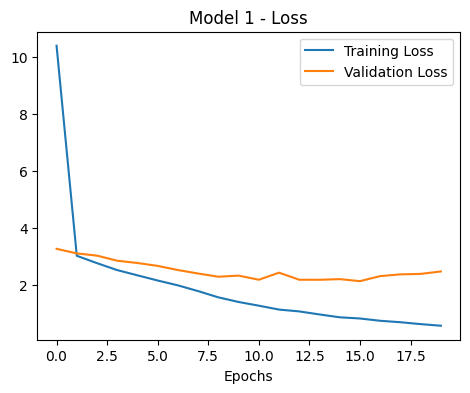

In [ ]:
# Plot the training and validation curves for the first model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model 1 - Loss')
plt.xlabel('Epochs')
plt.legend()


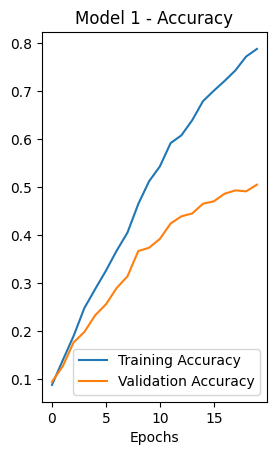

In [ ]:

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1 - Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()


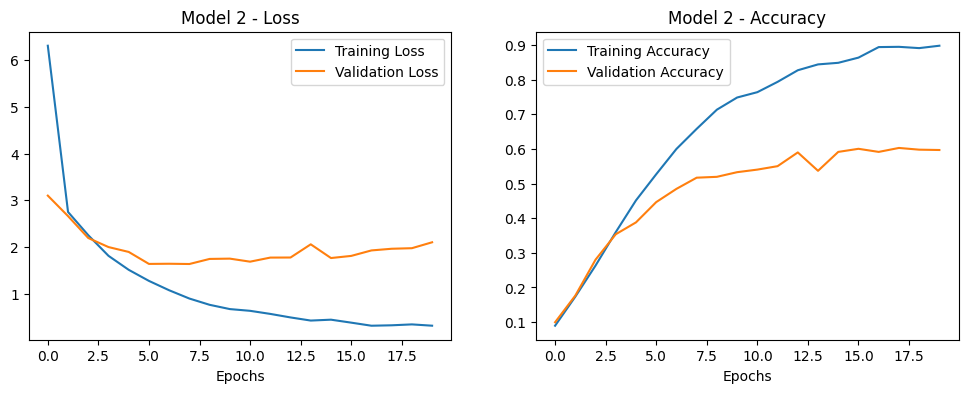

In [ ]:
# Plot the training and validation curves for the second model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model 2 - Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2 - Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()


In [ ]:
# Evaluate and save the best model
best_model = model1 if max(history1.history['val_accuracy']) > max(history2.history['val_accuracy']) else model2
best_model.save('best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

# Reload the best model
loaded_model = load_model('best_model.h5')

# Test the best model on the testing dataset
test_predictions = loaded_model.predict(test_images)
test_predictions_labels = np.argmax(test_predictions, axis=1)

# Calculate confusion matrix and average f1 score
conf_matrix = confusion_matrix(test_labels[0], test_predictions_labels)
average_f1_score = f1_score(test_labels[0], test_predictions_labels, average='macro')


105/105 [==============================] - 0s 2ms/step


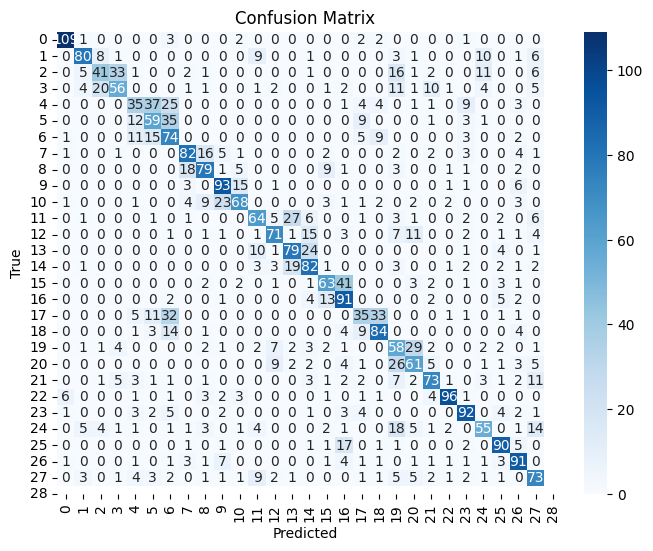

Average F1 Score: 0.603370882014415


In [ ]:
# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(test_labels_one_hot.shape[1]), yticklabels=range(test_labels_one_hot.shape[1]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f'Average F1 Score: {average_f1_score}')
